In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import cv2
import imageio
import getpass

import azure.storage.blob
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient


from tensorflow.keras.models import Model
import tensorflow.keras as keras
import tensorflow as tf
from keras.callbacks import Callback

import sys
sys.path.append('../../ml-workflow/') # point to wherever the ml-workflow directory is
import imp

import data_utils as du
import ml_models

from tqdm.auto import trange, tqdm
import concurrent.futures

# Need to comment out gray_image = cv2.cvtColor(ri, cv2.COLOR_BGR2GRAY) in du.prepocess_input
# gray_image = ri
from importlib import reload

In [2]:
import sys
sys.path.append('../PIVOT/') # point to wherever the ml-workflow directory is

import utils.data_utils as du
import utils.insert_data as idu
import utils.sql_utils as sq
from tqdm.auto import trange, tqdm
import concurrent.futures

# Need to comment out gray_image = cv2.cvtColor(ri, cv2.COLOR_BGR2GRAY) in du.prepocess_input
# gray_image = ri
from importlib import reload
reload(du)
reload(idu)
reload(sq)

<module 'utils.sql_utils' from 'C:\\Users\\ysman\\Desktop\\Capstone\\PIVOT\\notebooks\\../PIVOT\\utils\\sql_utils.py'>

## Get Data

In [9]:
train_data= pd.read_csv("../PIVOT/data/model-summary-cnn-v1-b3.csv")

In [10]:
train_data['filepath'] = train_data['full_path'].str.split("data/", expand=True)[1]

In [13]:
train_ids = sq.run_sql_query(
    """
    select I.i_id, I.filepath, m.d_value 
    from metrics as m 
    inner join images as I on I.I_ID = M.I_ID
    where m.I_ID < 399777;
    """)

In [17]:
train_data_full = train_data.merge(train_ids, on = 'filepath', how='inner').drop(columns='full_path')

In [21]:
train_data_full[['true_label', 'i_id']].groupby("true_label").count()/train_data_full.shape[0]

,i_id
true_label,
0,0.006031
1,0.001806
2,0.022645
3,0.111523
4,0.006596
5,0.070012
6,0.032758
7,0.635713
8,0.011114


Looks like #7, #9 dominates the sample set.

In [28]:
## time
downsampled = train_data_full.groupby('true_label', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=1))

In [33]:
%%time
container_name = 'naames'
account_name = 'ifcb'
url_prefix = f"https://{account_name}.blob.core.windows.net/{container_name}/"

CPU times: total: 0 ns
Wall time: 0 ns


## Load Model


In [8]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON file
json_file_path = '../../ml-workflow/model_ckpt/model-cnn-v1-b3.json'
with open(json_file_path, 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# Load the model weights from H5 file
h5_file_path = '../../ml-workflow/model_ckpt/model-cnn-v1-b3.h5'
loaded_model.load_weights(h5_file_path)

In [29]:
# Remove the last layer
pop_last_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output)

# Print the summary
pop_last_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 activation_12 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 activation_13 (Activation)  (None, 128, 128, 16)      0         
                                                             

In [31]:
# Remove the last layer
post_cnn_model = Model(inputs=loaded_model.input, outputs=loaded_model.layers[-10].output)

# Print the summary
post_cnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 activation_12 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 activation_13 (Activation)  (None, 128, 128, 16)      0         
                                                           

## Get Feature Vectors

In [70]:
cloud_urls = url_prefix + downsampled['filepath']

def get_predictions(cloud_urls):
    # Specify the batch size and number of workers
    batch_size = 320
    num_workers = 24  # Adjust based on your system's capabilities

    # Split URLs into batches
    start_index = 0
    url_batches = [cloud_urls[i:i + batch_size] for i in range(start_index, 
                                                               len(cloud_urls), 
                                                               batch_size)]

    # Create an empty list to store probabilities
    post_cnn_features = []
    pop_last_features = []

    # Create a list to store the order of URLs
    url_order = []

    # Define a function for parallel preprocessing
    def preprocess_batch(order_index, batch_urls):
        idxs = []
        data = []
        for i, c_url in enumerate(tqdm(batch_urls, leave=False)):
            try:
                data.append(du.preprocess_input(np.expand_dims(imageio.v2.imread(c_url), axis=-1)))
                idxs.append(order_index*batch_size + i + start_index)
            except:
                continue

        result = (idxs, data)
        return result

    try:
        # Use concurrent.futures for parallel processing
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
            future_to_order_index = {
                executor.submit(preprocess_batch, i, batch_urls): i 
                for i, batch_urls in enumerate(url_batches)
            }
            for future in tqdm(concurrent.futures.as_completed(future_to_order_index), total=len(url_batches)):
                order_index = future_to_order_index[future]
                try:
                    # Get batch of images
                    url_idxs, img_data = future.result()
                    url_order.extend(url_idxs)

                    # predict images
                    post_cnn_batch = post_cnn_model.predict(np.array(img_data), verbose=0)
                    post_cnn_features.extend(post_cnn_batch)

                    pop_last_batch = pop_last_model.predict(np.array(img_data), verbose=0)
                    pop_last_features.extend(pop_last_batch)

                except Exception as e:
                    print(f"Error processing batch {order_index}: {e}")

    except KeyboardInterrupt:
        print("Process interrupted by user.")

    # Sort results based on the original order of URLs
    sorted_indices = np.argsort(url_order)
    ordered_post_cnn = np.vstack(post_cnn_features)[sorted_indices]
    ordered_pop_last = np.vstack(pop_last_features)[sorted_indices]

    sorted_urls = np.array(cloud_urls)[url_order]
    sorted_urls = sorted_urls[sorted_indices]
    
    
    return sorted_urls, ordered_pop_last, ordered_post_cnn

In [73]:
round2_c_urls = url_prefix + downsampled[~downsampled.i_id.isin(sorted_I_IDs)].filepath
r2_sorted_urls, r2_ordered_pop_last, r2_ordered_post_cnn = get_predictions(round2_c_urls)

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [45]:
sorted_indices

array([ 5760,  5761,  5762, ..., 82980, 82981, 82982], dtype=int64)

In [86]:
r2_i_ids = pd.DataFrame({'filepath': pd.Series(r2_sorted_urls).str.split("naames/", expand=True)[1]}).merge(downsampled, on='filepath').i_id.values

In [58]:
sorted_I_IDs = np.array(downsampled.i_id)[url_order]
sorted_I_IDs = sorted_I_IDs[sorted_indices]

In [69]:
round1 = {
    'I_IDs': sorted_I_IDs,
    'pop_last': ordered_pop_last,
    'post_cnn': ordered_post_cnn
}

In [88]:
round2 = {
    'I_IDs': r2_i_ids,
    'pop_last': r2_ordered_pop_last,
    'post_cnn': r2_ordered_post_cnn
}

In [105]:
total_downsampled = {
    'I_IDs' : list(sorted_I_IDs)+list(r2_i_ids),
    'pop_last' : np.vstack([ordered_pop_last, r2_ordered_pop_last]),
    'post_cnn' : np.vstack([ordered_post_cnn, r2_ordered_post_cnn])
}

In [107]:
total_downsampled_df = pd.DataFrame({"i_id": total_downsampled['I_IDs']}).merge(downsampled, on='i_id')

##  Plot representations

In [208]:
class_map = sq.get_class_map(model_id=1)

In [209]:
class_map

{0: 'Chloro',
 1: 'Cilliate',
 2: 'Crypto',
 3: 'Diatom',
 4: 'Dictyo',
 5: 'Dinoflagellate',
 6: 'Eugleno',
 7: 'Other',
 8: 'Prymnesio',
 9: 'Unidentifiable'}

In [117]:
total_downsampled_df.true_label

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### Pop Last

In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap

# Generate sample data (replace these with your actual data)
# N = 1000  # Number of samples
# D = 50    # Dimensionality of the data
num_classes = 10  # Number of classes

# Creating a random matrix of NxD and a vector of N x 1 for different class labels
data_matrix = total_downsampled['pop_last']
class_labels = total_downsampled_df.true_label

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_matrix)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data_matrix)

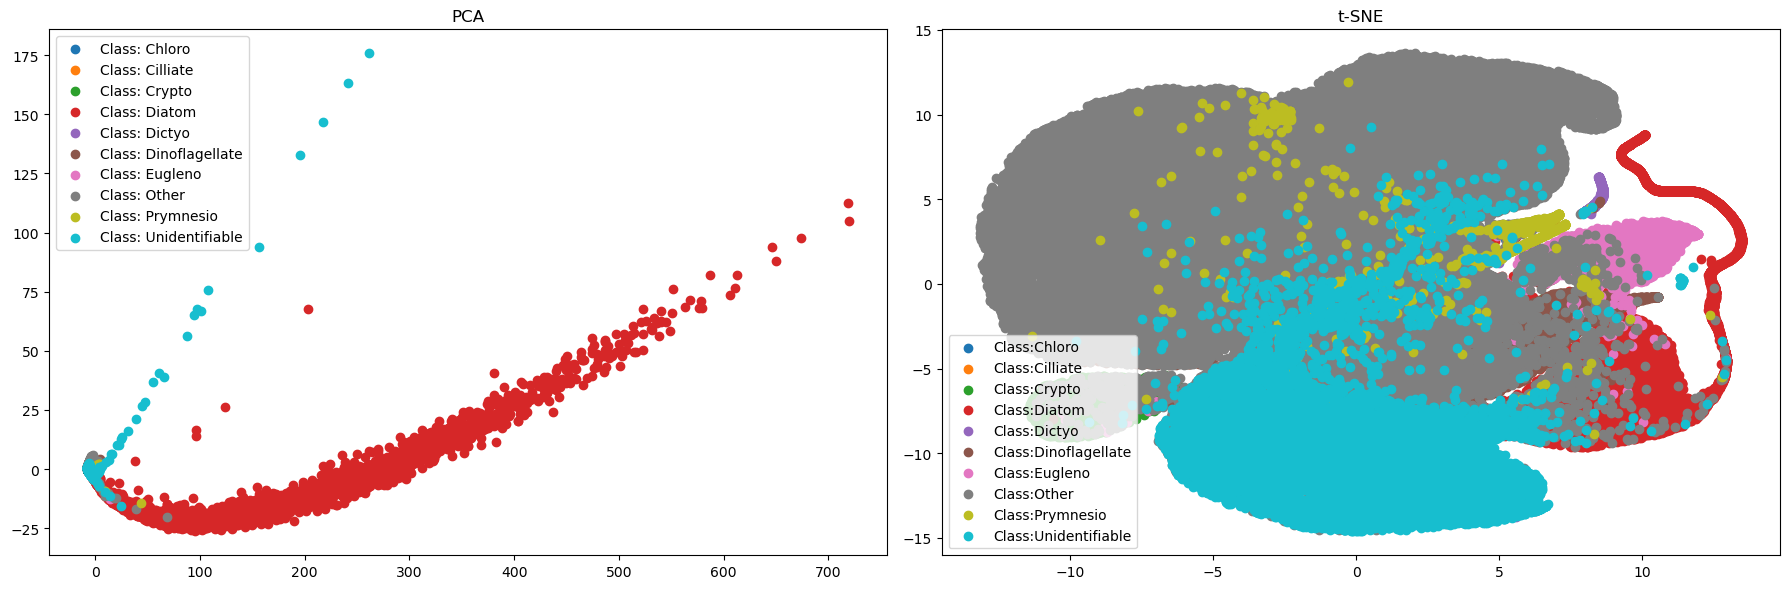

CPU times: total: 5.69 s
Wall time: 5.93 s


In [210]:
%%time
# UMAP
# umap_reducer = umap.UMAP(n_components=2)
# umap_result = umap_reducer.fit_transform(data_matrix)

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for label in range(num_classes):
    indices = np.where(class_labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class: {class_map[label]}')
plt.title('PCA')
plt.legend()

plt.subplot(1, 2, 2)
for label in range(num_classes):
    indices = np.where(class_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Class:{class_map[label]}')
plt.title('t-SNE')
plt.legend()

# plt.subplot(1, 3, 3)
# for label in range(num_classes):
#     indices = np.where(class_labels == label)
#     plt.scatter(umap_result[indices, 0], umap_result[indices, 1], label=f'Class {label}')
# plt.title('UMAP')
# plt.legend()

plt.tight_layout()
plt.show()

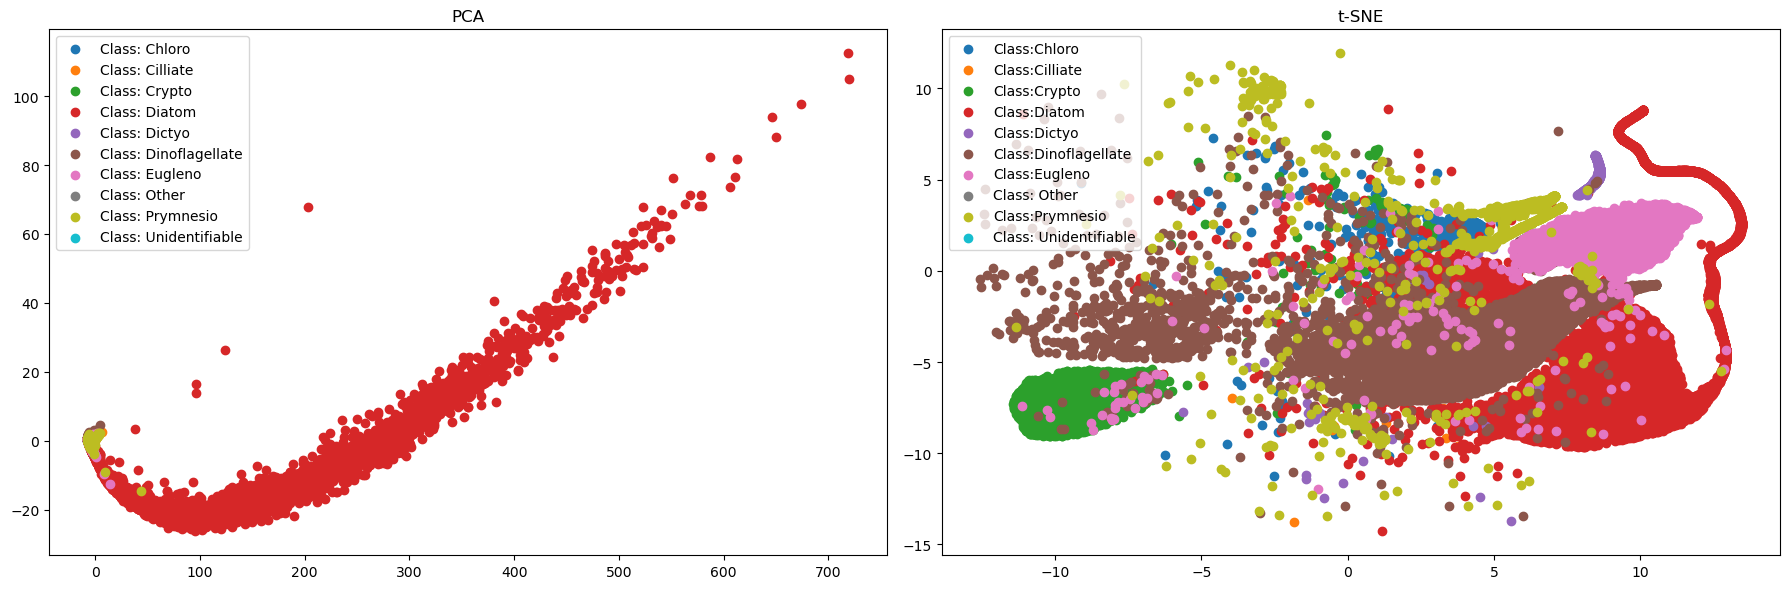

CPU times: total: 2.02 s
Wall time: 2 s


In [212]:
%%time
# UMAP
# umap_reducer = umap.UMAP(n_components=2)
# umap_result = umap_reducer.fit_transform(data_matrix)

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for label in range(num_classes):
    if label in [7,9]:
        plt.scatter([],[], label=f'Class: {class_map[label]}')
        continue
    indices = np.where(class_labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class: {class_map[label]}')
plt.title('PCA')
plt.legend()

plt.subplot(1, 2, 2)
for label in range(num_classes):
    if label in [7,9]:
        plt.scatter([],[], label=f'Class: {class_map[label]}')
        continue
    indices = np.where(class_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Class:{class_map[label]}')
plt.title('t-SNE')
plt.legend()

# plt.subplot(1, 3, 3)
# for label in range(num_classes):
#     indices = np.where(class_labels == label)
#     plt.scatter(umap_result[indices, 0], umap_result[indices, 1], label=f'Class {label}')
# plt.title('UMAP')
# plt.legend()

plt.tight_layout()
plt.show()

### Post CNN

In [213]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap

# Generate sample data (replace these with your actual data)
# N = 1000  # Number of samples
# D = 50    # Dimensionality of the data
num_classes = 10  # Number of classes

# Creating a random matrix of NxD and a vector of N x 1 for different class labels
data_matrix = total_downsampled['post_cnn']
class_labels = total_downsampled_df.true_label

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_matrix)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data_matrix)

CPU times: total: 25min 27s
Wall time: 6min 33s


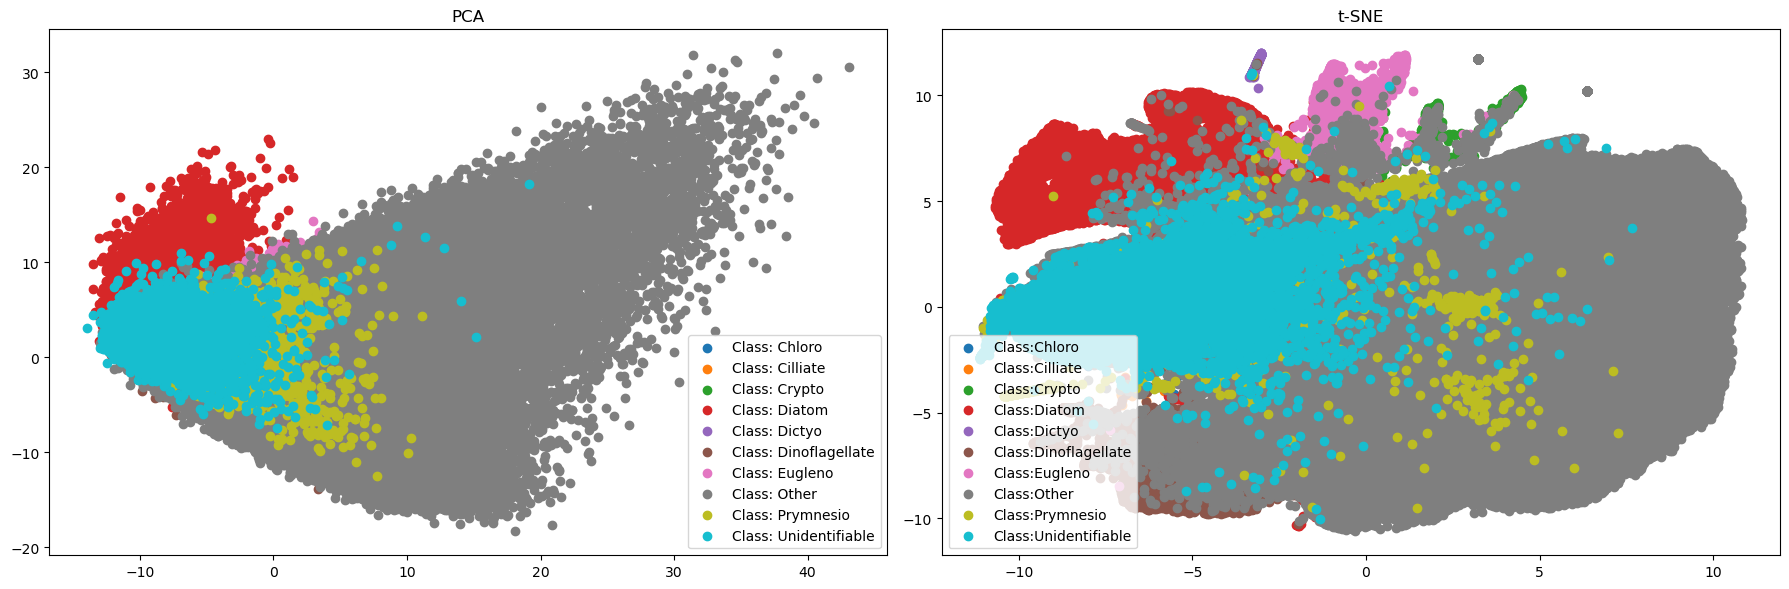

CPU times: total: 6.36 s
Wall time: 6.39 s


In [214]:
%%time
# UMAP
# umap_reducer = umap.UMAP(n_components=2)
# umap_result = umap_reducer.fit_transform(data_matrix)

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for label in range(num_classes):
    indices = np.where(class_labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class: {class_map[label]}')
plt.title('PCA')
plt.legend()

plt.subplot(1, 2, 2)
for label in range(num_classes):
    indices = np.where(class_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Class:{class_map[label]}')
plt.title('t-SNE')
plt.legend()

# plt.subplot(1, 3, 3)
# for label in range(num_classes):
#     indices = np.where(class_labels == label)
#     plt.scatter(umap_result[indices, 0], umap_result[indices, 1], label=f'Class {label}')
# plt.title('UMAP')
# plt.legend()

plt.tight_layout()
plt.show()

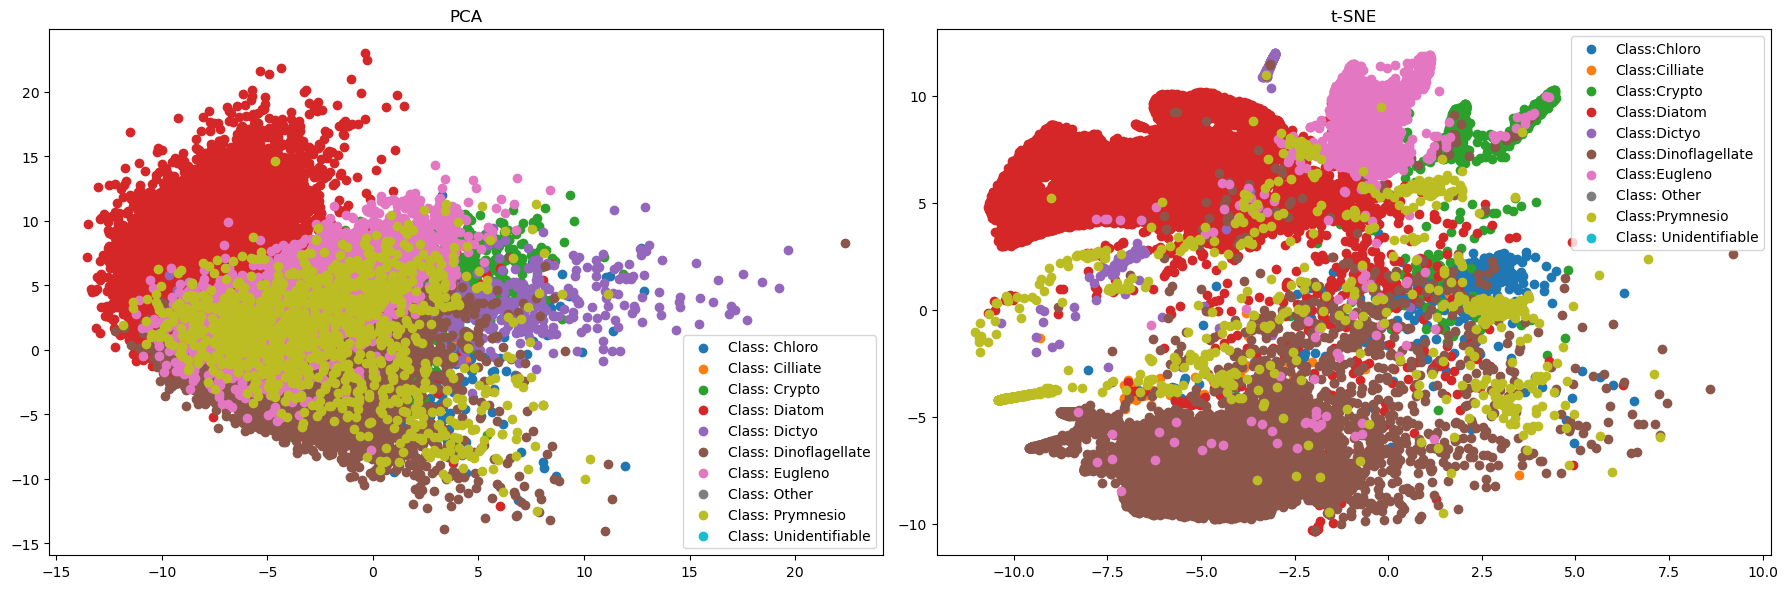

CPU times: total: 2.16 s
Wall time: 2.15 s


In [215]:
%%time
# UMAP
# umap_reducer = umap.UMAP(n_components=2)
# umap_result = umap_reducer.fit_transform(data_matrix)

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for label in range(num_classes):
    if label in [7,9]:
        plt.scatter([],[], label=f'Class: {class_map[label]}')
        continue
    indices = np.where(class_labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class: {class_map[label]}')
plt.title('PCA')
plt.legend()

plt.subplot(1, 2, 2)
for label in range(num_classes):
    if label in [7,9]:
        plt.scatter([],[], label=f'Class: {class_map[label]}')
        continue
    indices = np.where(class_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Class:{class_map[label]}')
plt.title('t-SNE')
plt.legend()

# plt.subplot(1, 3, 3)
# for label in range(num_classes):
#     indices = np.where(class_labels == label)
#     plt.scatter(umap_result[indices, 0], umap_result[indices, 1], label=f'Class {label}')
# plt.title('UMAP')
# plt.legend()

plt.tight_layout()
plt.show()

In [232]:
reload(sq)
r = sq.get_label_rank_df(model_id=1,dissimilarity_id=1, random_ratio=1)

In [233]:
r.head()

,IMAGE_ID,BLOB_FILEPATH,UNCERTAINTY,PRED_LABEL,PROBS,RANK_SCORE
0,987746,NAAMES_ml/D20151107T045554_IFCB107/IFCB107D201...,1.0,Other,"{'Chloro': 1.3667162e-05, 'Cilliate': 2.769038...",1.0
1,1229606,NAAMES_ml/D20160531T020746_IFCB107/IFCB107D201...,1.0,Other,"{'Chloro': 0.000110751345, 'Cilliate': 8.44415...",1.0
2,842150,NAAMES_ml/D20170917T061120_IFCB107/IFCB107D201...,1.0,Other,"{'Chloro': 8.978316e-07, 'Cilliate': 5.241747e...",1.0
3,892277,NAAMES_ml/D20160513T212110_IFCB107/IFCB107D201...,1.0,Other,"{'Chloro': 0.00053186476, 'Cilliate': 1.930749...",1.0
4,1042606,NAAMES_ml/D20160512T101649_IFCB107/IFCB107D201...,1.0,Other,"{'Chloro': 0.0054884683, 'Cilliate': 2.9233943...",1.0


In [248]:
total_downsampled.keys()

dict_keys(['I_IDs', 'pop_last', 'post_cnn'])

In [253]:
import pickle
import gzip

with gzip.open("total_downsampled.pickle.gz", 'wb') as f:
    pickle.dump(total_downsampled, f)

In [252]:
import 
with open("total_ds_i_ids.pickle", 'wb') as f:
    pickle.dump(total_downsampled['I_IDs'], f)
with open("total_ds_pop_last.pickle", 'wb') as f:
    pickle.dump(total_downsampled['pop_last'], f)
with open("total_ds_post_cnn.pickle", 'wb') as f:
    pickle.dump(total_downsampled['post_cnn'], f)
    